In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
from IPython.core.debugger import set_trace

Text(0.5, 1.0, 'Two Moons Data')

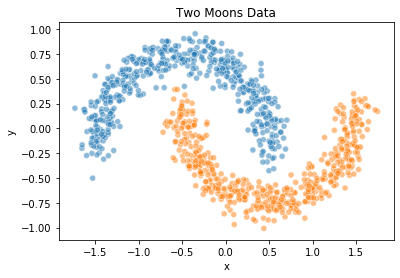

In [2]:
n_samples = 1000
n_noisy_dimensions = 1000

X, y = datasets.make_moons(n_samples=n_samples, noise=0.1)
X = (X - X.mean(axis=0)).astype(np.float32)

# Scatter plot, dots colored by class value
df = pd.DataFrame(data = {"x": X[:,0], "y": X[:,1], "category": y})
sns.scatterplot(
    x="x",
    y="y",
    data=df,
    hue="category",
    legend=False,
    alpha=0.5
).set_title("Two Moons Data")

In [3]:
from models import MLP
import torch
from torch import optim
from torch.nn import MSELoss
from torch.nn import CrossEntropyLoss

torch.manual_seed(42)

In [4]:
from sklearn.model_selection import train_test_split
from data import Experiment
from torch.utils.data import DataLoader

batch_size=32

noise = np.random.normal(loc=1, scale=2.0, size=(n_samples, n_noisy_dimensions))
X_with_noise = np.concatenate((X, noise), axis=1)
X_with_noise = X_with_noise.astype(np.float32)

experiment = Experiment(X = X_with_noise, y = y)
train_loader = DataLoader(experiment.train_dataset, batch_size=batch_size)

# Set the batch size to load all data at once for testing
test_loader = DataLoader(experiment.test_dataset, batch_size=experiment.test_dataset.y.shape[0])

num_training_epochs=600

In [5]:
D_in = experiment.train_dataset.X.shape[1]
H1 = D_in // 2
H2 = H1 // 2
D_out = 2
dropout = 0.2

f1 = MLP(D_in = D_in, H1 = H1, H2 = H2, D_out = D_out, dropout = dropout).cuda()
f1_optimizer = optim.Adam(f1.parameters(), lr=1e-5, weight_decay=5e-3)

Running this next cell demonstrates that a basic MLP only learns noise in the data, and not any meaningful features.

In [6]:
criterion = CrossEntropyLoss()

mlp_accuracies = []
def train(model, num_epochs, batch_size):
    
    print("Beginning model training at {}".format(datetime.datetime.now()))
    
    for epoch in range(num_epochs):
        start_time = time.time()
        for X_batch, y_batch in train_loader:
            y_batch = y_batch.squeeze()
            X_batch = torch.FloatTensor(X_batch).cuda()
            y_batch = torch.LongTensor(y_batch).cuda()
            model.train()
            f1_optimizer.zero_grad()
            
            output = model(X_batch)
            loss_train = criterion(output, y_batch)
            #print("Train Loss: {}".format(loss_train))
            
            loss_train.backward()
            f1_optimizer.step()
            
        for X_batch, y_batch in test_loader:
            y_batch = y_batch.squeeze()
            X_batch = torch.FloatTensor(X_batch).cuda()
            y_batch = torch.LongTensor(y_batch).cuda()
            model.eval()
            output = model(X_batch)
            loss_test = criterion(output, y_batch).item()
            class_probabilities = torch.nn.Softmax()(output)
            predicted_classes = torch.argmax(class_probabilities, dim=1)
            correct_predictions = (predicted_classes == y_batch).float()
            accuracy = (correct_predictions.sum()/correct_predictions.shape[0]).item()
            #set_trace()
            end_time = time.time()
            epoch_time = end_time - start_time
            mlp_accuracies.append(accuracy)
        
        if epoch % 10 == 0:
            print("Epoch {} completed in {} secs with test loss, accuracy {:.4f},{:.4f}".format(epoch, epoch_time, loss_test, accuracy))

In [7]:
train(f1, num_training_epochs, batch_size)

Beginning model training at 2019-11-17 14:19:05.497729
Epoch 0 completed in 0.09676098823547363 secs with test loss, accuracy 0.6999,0.4700


/homes/gws/ewein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 10 completed in 0.08618807792663574 secs with test loss, accuracy 0.6960,0.4950
Epoch 20 completed in 0.07817673683166504 secs with test loss, accuracy 0.6965,0.4850
Epoch 30 completed in 0.08404874801635742 secs with test loss, accuracy 0.7009,0.4900
Epoch 40 completed in 0.07886672019958496 secs with test loss, accuracy 0.7100,0.5250
Epoch 50 completed in 0.07694602012634277 secs with test loss, accuracy 0.7309,0.5150
Epoch 60 completed in 0.08291363716125488 secs with test loss, accuracy 0.7636,0.5350
Epoch 70 completed in 0.09074974060058594 secs with test loss, accuracy 0.8026,0.5450
Epoch 80 completed in 0.07980108261108398 secs with test loss, accuracy 0.8498,0.5400
Epoch 90 completed in 0.0844411849975586 secs with test loss, accuracy 0.8979,0.5350
Epoch 100 completed in 0.0779883861541748 secs with test loss, accuracy 0.9436,0.5300
Epoch 110 completed in 0.07689714431762695 secs with test loss, accuracy 0.9832,0.5400
Epoch 120 completed in 0.0821685791015625 secs with te

In [8]:
import egexplainer
import importlib

importlib.reload(egexplainer)

APExp = egexplainer.VariableBatchExplainer(experiment.train_dataset, 102)

In [9]:
from models import LinearModel

D_in = experiment.train_dataset.X.shape[1]
H1 = D_in // 2
H2 = H1 // 2
D_out = 2
dropout = 0.2

f1 = MLP(D_in = D_in, H1 = H1, H2 = H2, D_out = D_out, dropout = dropout).cuda()
f1_optimizer = optim.Adam(f1.parameters(), lr=1e-5, weight_decay=5e-3)

std = experiment.train_dataset.X.std(axis=0).reshape(-1,1)
mean = experiment.train_dataset.X.mean(axis=0).reshape(-1,1)

prior_info = np.concatenate((std, mean), axis=1)
prior_info = torch.FloatTensor(prior_info).cuda()

D_in = prior_info.shape[1]

f2 = LinearModel(D_in = D_in, D_out = 1).cuda()
f2_optimizer = optim.Adam(f2.parameters(), lr=5e-5, weight_decay=5e-3)

In [10]:
prior_accuracies = []
def train_with_learned_prior(f1, f2, num_epochs, batch_size):
     
    classification_criterion = CrossEntropyLoss()
    
    print("Beginning model training at {}".format(datetime.datetime.now()))
    
    for epoch in range(num_epochs):
        start_time = time.time()
        f1.train()
        f2.train()
        
        for X_batch, y_batch in train_loader:
            y_batch = y_batch.squeeze()
            X_batch = torch.FloatTensor(X_batch).cuda()
            y_batch = torch.LongTensor(y_batch).cuda()
        
            f1_optimizer.zero_grad()
            f2_optimizer.zero_grad()
            
            output = f1(X_batch)
            classification_loss = classification_criterion(output, y_batch)
            
            eg = APExp.shap_values(f1, X_batch, sparse_labels=y_batch)
            prior_differences = f2(prior_info).squeeze()
            
            # This works pretty well! Why?
            prior_loss = (prior_differences - eg).abs().mean()
            train_loss = classification_loss + prior_loss
            
            train_loss.backward()
            f1_optimizer.step()
            f2_optimizer.step()
            
        
        f1.eval()
        for X_batch, y_batch in test_loader:
            y_batch = y_batch.squeeze()
            X_batch = torch.FloatTensor(X_batch).cuda()
            y_batch = torch.LongTensor(y_batch).cuda()
            output = f1(X_batch)
            loss_test = classification_criterion(output, y_batch)
            
            class_probabilities = torch.nn.Softmax()(output)
            predicted_classes = torch.argmax(class_probabilities, dim=1)
            correct_predictions = (predicted_classes == y_batch).float()
            accuracy = (correct_predictions.sum()/correct_predictions.shape[0]).item()
            end_time = time.time()
            epoch_time = end_time - start_time
            prior_accuracies.append(accuracy)
            
        if epoch % 10 == 0:
            print("Epoch {} completed in {} secs with test loss, accuracy {:.4f},{:.4f}".format(epoch, epoch_time, loss_test, accuracy))

In [11]:
train_with_learned_prior(f1, f2, num_training_epochs, 32)

Beginning model training at 2019-11-17 14:19:55.298428


/homes/gws/ewein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0 completed in 0.2308645248413086 secs with test loss, accuracy 0.6940,0.5400
Epoch 10 completed in 0.22703766822814941 secs with test loss, accuracy 0.6902,0.5500
Epoch 20 completed in 0.23113679885864258 secs with test loss, accuracy 0.6873,0.5450
Epoch 30 completed in 0.2218611240386963 secs with test loss, accuracy 0.6836,0.5500
Epoch 40 completed in 0.21449899673461914 secs with test loss, accuracy 0.6859,0.5550
Epoch 50 completed in 0.22640442848205566 secs with test loss, accuracy 0.6977,0.5600
Epoch 60 completed in 0.21140408515930176 secs with test loss, accuracy 0.7212,0.5700
Epoch 70 completed in 0.2192544937133789 secs with test loss, accuracy 0.7538,0.5650
Epoch 80 completed in 0.21226930618286133 secs with test loss, accuracy 0.7930,0.5550
Epoch 90 completed in 0.20990538597106934 secs with test loss, accuracy 0.8329,0.5600
Epoch 100 completed in 0.2183847427368164 secs with test loss, accuracy 0.8656,0.5600
Epoch 110 completed in 0.22368550300598145 secs with test 

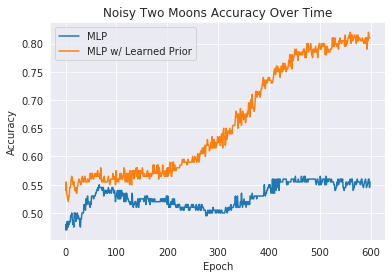

In [45]:
sns.set_style("darkgrid")
plt.plot(mlp_accuracies, label="MLP")
plt.plot(prior_accuracies, label="MLP w/ Learned Prior")
plt.title("Noisy Two Moons Accuracy Over Time")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

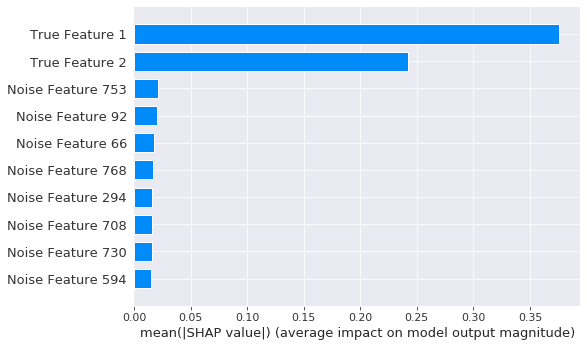

In [44]:
import shap

real_feature_names = ["True Feature 1", "True Feature 2"]
noisy_feature_names = ["Noise Feature {}".format(str(i)) for i in range(n_noisy_dimensions)]
all_feature_names = real_feature_names + noisy_feature_names

for X_batch, y_batch in test_loader:
    y_batch = y_batch.squeeze()
    X_batch = torch.FloatTensor(X_batch).cuda()
    y_batch = torch.LongTensor(y_batch).cuda()
    eg = APExp.shap_values(f1, X_batch, sparse_labels=y_batch).cpu().detach().numpy()
    shap.summary_plot(
        eg,
        X_batch,
        plot_type="bar",
        feature_names=all_feature_names,
        max_display=10
    )